# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 19, 22, 36, 10, 102556)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# with open('./data/hopsworks-api-key.txt', 'r', encoding='utf-8') as file:
#     os.environ["HOPSWORKS_API_KEY"] = file.read()

In [4]:
project = hopsworks.login()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1149079


In [5]:
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [7]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [8]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=11,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [9]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.530681E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [10]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [11]:
batch_data_weather = weather_fg.filter(weather_fg.date >= today).read()
batch_data_weather

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.73s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-22 00:00:00+00:00,2.20,0.2,13.044724,242.020615,paris
1,2024-11-20 00:00:00+00:00,7.00,0.0,16.622490,287.650208,paris
2,2024-11-27 00:00:00+00:00,5.75,0.0,8.427383,19.983198,paris
3,2024-11-24 00:00:00+00:00,18.15,0.0,29.215502,202.456985,paris
4,2024-11-28 00:00:00+00:00,5.00,0.2,12.646200,4.899013,paris
5,2024-11-25 00:00:00+00:00,11.80,0.6,10.105681,265.914459,paris
6,2024-11-21 00:00:00+00:00,2.05,0.5,11.620809,73.810730,paris
7,2024-11-26 00:00:00+00:00,10.15,0.0,13.627795,257.799561,paris
8,2024-11-23 00:00:00+00:00,4.55,0.0,19.161337,154.397858,paris


In [12]:
batch_data_aq = air_quality_fg.filter(air_quality_fg.date >= today).read()
batch_data_aq

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.87s) 


,date,pm25,country,city,street,url,pm25_3days


In [13]:
batch_data = pd.concat([batch_data_aq, batch_data_weather])[['date', 'pm25_3days', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']]
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,pm25_3days,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
1,2024-11-20 00:00:00+00:00,NaN,7.00,0.0,16.622490,287.650208
6,2024-11-21 00:00:00+00:00,NaN,2.05,0.5,11.620809,73.810730
0,2024-11-22 00:00:00+00:00,NaN,2.20,0.2,13.044724,242.020615
8,2024-11-23 00:00:00+00:00,NaN,4.55,0.0,19.161337,154.397858
3,2024-11-24 00:00:00+00:00,NaN,18.15,0.0,29.215502,202.456985
5,2024-11-25 00:00:00+00:00,NaN,11.80,0.6,10.105681,265.914459
7,2024-11-26 00:00:00+00:00,NaN,10.15,0.0,13.627795,257.799561
2,2024-11-27 00:00:00+00:00,NaN,5.75,0.0,8.427383,19.983198
4,2024-11-28 00:00:00+00:00,NaN,5.00,0.2,12.646200,4.899013


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [14]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['pm25_3days', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,pm25_3days,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25
1,2024-11-20 00:00:00+00:00,NaN,7.00,0.0,16.622490,287.650208,33.318329
6,2024-11-21 00:00:00+00:00,NaN,2.05,0.5,11.620809,73.810730,49.995911
0,2024-11-22 00:00:00+00:00,NaN,2.20,0.2,13.044724,242.020615,53.873680
8,2024-11-23 00:00:00+00:00,NaN,4.55,0.0,19.161337,154.397858,43.607765
3,2024-11-24 00:00:00+00:00,NaN,18.15,0.0,29.215502,202.456985,14.065085
5,2024-11-25 00:00:00+00:00,NaN,11.80,0.6,10.105681,265.914459,33.454174
7,2024-11-26 00:00:00+00:00,NaN,10.15,0.0,13.627795,257.799561,39.447666
2,2024-11-27 00:00:00+00:00,NaN,5.75,0.0,8.427383,19.983198,59.069328
4,2024-11-28 00:00:00+00:00,NaN,5.00,0.2,12.646200,4.899013,62.515526


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 4
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   pm25_3days                   0 non-null      float64            
 2   temperature_2m_mean          9 non-null      float32            
 3   precipitation_sum            9 non-null      float32            
 4   wind_speed_10m_max           9 non-null      float32            
 5   wind_direction_10m_dominant  9 non-null      float32            
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), float64(1)
memory usage: 396.0 bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [16]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,pm25_3days,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,street,city,country,days_before_forecast_day
1,2024-11-20 00:00:00+00:00,NaN,7.00,0.0,16.622490,287.650208,33.318329,18eme,paris,france,1
6,2024-11-21 00:00:00+00:00,NaN,2.05,0.5,11.620809,73.810730,49.995911,18eme,paris,france,2
0,2024-11-22 00:00:00+00:00,NaN,2.20,0.2,13.044724,242.020615,53.873680,18eme,paris,france,3
8,2024-11-23 00:00:00+00:00,NaN,4.55,0.0,19.161337,154.397858,43.607765,18eme,paris,france,4
3,2024-11-24 00:00:00+00:00,NaN,18.15,0.0,29.215502,202.456985,14.065085,18eme,paris,france,5
5,2024-11-25 00:00:00+00:00,NaN,11.80,0.6,10.105681,265.914459,33.454174,18eme,paris,france,6
7,2024-11-26 00:00:00+00:00,NaN,10.15,0.0,13.627795,257.799561,39.447666,18eme,paris,france,7
2,2024-11-27 00:00:00+00:00,NaN,5.75,0.0,8.427383,19.983198,59.069328,18eme,paris,france,8
4,2024-11-28 00:00:00+00:00,NaN,5.00,0.2,12.646200,4.899013,62.515526,18eme,paris,france,9


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 1 to 4
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   pm25_3days                   0 non-null      float64            
 2   temperature_2m_mean          9 non-null      float32            
 3   precipitation_sum            9 non-null      float32            
 4   wind_speed_10m_max           9 non-null      float32            
 5   wind_direction_10m_dominant  9 non-null      float32            
 6   predicted_pm25               9 non-null      float32            
 7   street                       9 non-null      object             
 8   city                         9 non-null      object             
 9   country                      9 non-null      object             
 10  days_before_forecast_day     9 non-null      int64         

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

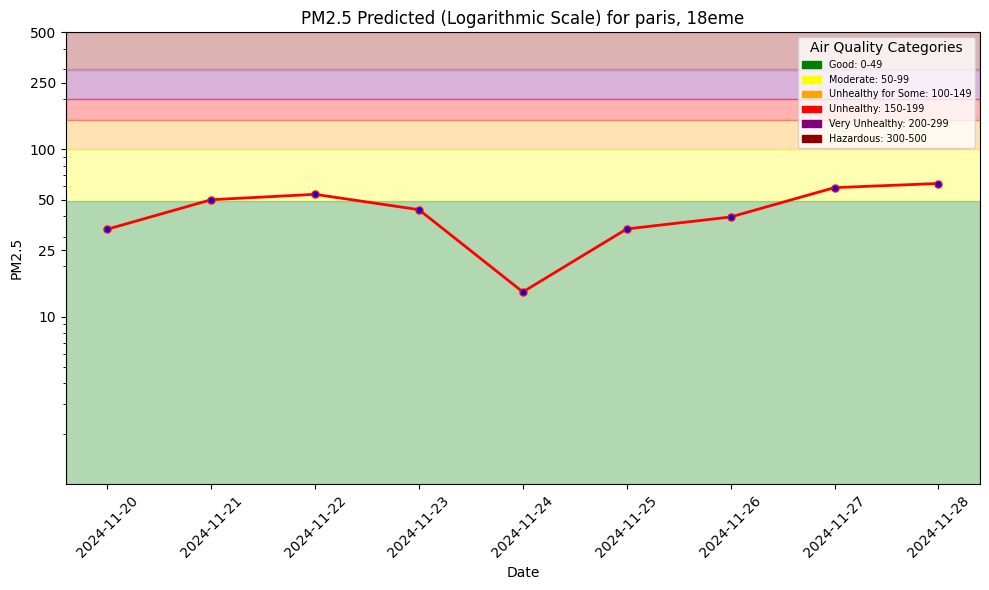

In [18]:
file_path = "./docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [19]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [20]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1149079/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x276cf459c40>, None)

In [21]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 


,date,pm25_3days,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25,street,city,country,days_before_forecast_day
0,2024-11-22 00:00:00+00:00,NaN,3.65,0.0,17.555305,254.538727,79.259521,18eme,paris,france,1
1,2024-11-20 00:00:00+00:00,NaN,7.00,0.0,16.622490,287.650208,33.318329,18eme,paris,france,1
2,2024-11-19 00:00:00+00:00,NaN,11.75,0.7,28.394392,230.659500,40.785843,18eme,paris,france,1


In [22]:
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 


,date,pm25,country,city,street,url,pm25_3days
0,2024-01-20 00:00:00+00:00,66.0,france,paris,18eme,https://api.waqi.info/feed/@3082,67.333333
1,2022-06-19 00:00:00+00:00,57.0,france,paris,18eme,https://api.waqi.info/feed/@3082,66.000000
2,2024-04-19 00:00:00+00:00,23.0,france,paris,18eme,https://api.waqi.info/feed/@3082,61.500000
3,2024-08-13 00:00:00+00:00,38.0,france,paris,18eme,https://api.waqi.info/feed/@3082,48.666667
4,2022-11-25 00:00:00+00:00,51.0,france,paris,18eme,https://api.waqi.info/feed/@3082,39.333333
...,...,...,...,...,...,...,...
1637,2023-01-23 00:00:00+00:00,69.0,france,paris,18eme,https://api.waqi.info/feed/@3082,43.000000
1638,2022-02-23 00:00:00+00:00,48.0,france,paris,18eme,https://api.waqi.info/feed/@3082,55.333333
1639,2022-02-06 00:00:00+00:00,22.0,france,paris,18eme,https://api.waqi.info/feed/@3082,52.333333
1640,2023-08-09 00:00:00+00:00,23.0,france,paris,18eme,https://api.waqi.info/feed/@3082,46.333333


In [23]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

In [24]:
# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)

In [25]:
hindcast_df

,date,predicted_pm25,pm25
0,2024-11-19 00:00:00+00:00,40.785843,1.0


### Plot the Hindcast comparing predicted with forecasted values (3-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

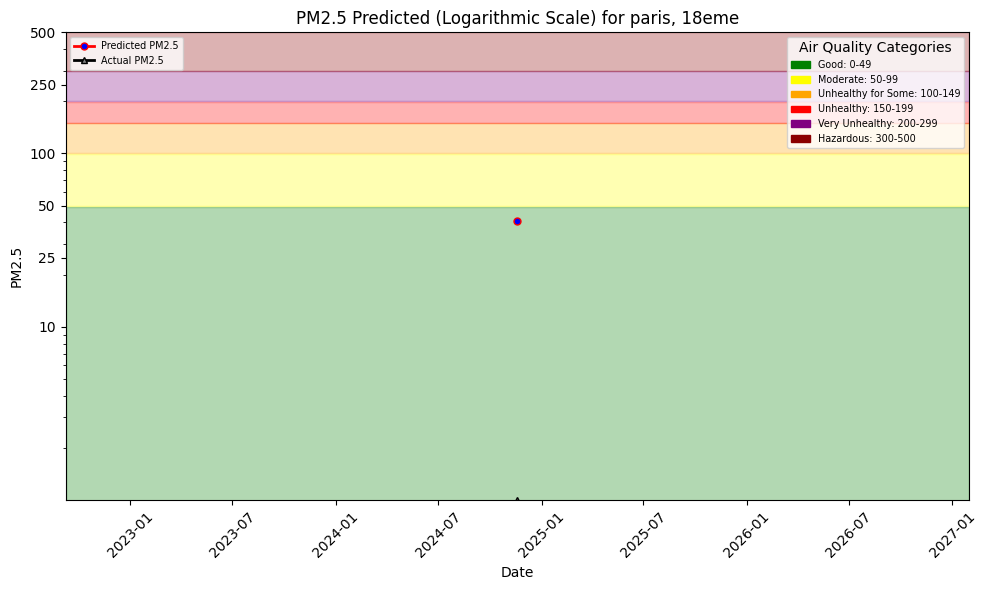

In [26]:
file_path = "./docs/air-quality/assets/img/pm25_hindcast_3days.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()